# Examining SMP Profiles with Graupel

**Goal**: See if we can see graupel in SMP profiles at a pit with known graupel layer

**Approach**:

1. Using a site location, retrieve all SMP profiles
2. Grab the graupel layer information from the hand_hardness profile
3. Plot all SMP locations with the Pit location as well.
4. Plot the SMP profiles and high light where graupel was mentioned in the hand hardness profiles comments


## Process

### Step 1. Grab the SMP profiles and convert to a dataframe

In [5]:
from snowexsql.data import LayerData, SiteData
from snowexsql.conversions import query_to_geopandas
from snowexsql.db import get_db
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np

# Site ID we know had graupel
site = '5S21'

# Connect to the database we made.
db_name = 'db.snowexdata.org/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

# Query the database looking at SMP profiles at our site
qry = session.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site))

# Convert SMP profiles to geopandas dataframe
df = query_to_geopandas(qry, engine)

### Step 2. Grab the hand hardness profile to highlight the graupel layer

In [6]:
# Grab hand hardness profiles at our site only
qry = session.query(LayerData).filter(LayerData.type == 'hand_hardness')
qry = qry.filter(LayerData.site_id == site)

# Convert the results to a dataframe
hh = query_to_geopandas(qry, engine)

# Find the word graupel in the comments
qry = qry.filter(LayerData.comments.contains('graupel'))
graupel = query_to_geopandas(qry, engine).iloc[0]

# Get the distance below surface to use with SMP data 
graupel['depth'] = graupel['depth'] - (hh['depth'].max())
graupel['bottom_depth'] = graupel['bottom_depth'] - hh['depth'].max()

print("Graupel Layer is between {} - {} cm below surface a site {}".format(graupel['depth'], graupel['bottom_depth'], site))
print('Notes on the Graupel Layer: "{}"'.format(graupel['comments']))
print('')

# Close the geoalchemy2 session
session.close()

Graupel Layer is between -28.0 - -30.0 cm below surface a site 5S21
Notes on the Graupel Layer: "Graupel layer, 6mm graupel"





### Step 3. Plot all the profile locations to see if the data looks like 2 cardinally aligned transects tyring to show acquisition order
SMP profiles were taken in transects aligned with cardinal directions. Lets see if thats what we have.


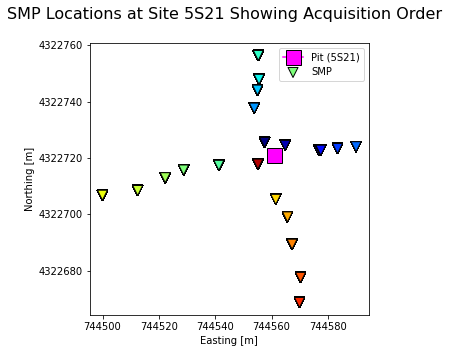

In [7]:
# Plot SMP profile locations with colored by the time they were taken using upside down triangles
ax = df.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# Plot pit location as a magenta square
ax.plot(graupel.easting, graupel.northing, markeredgecolor='black', color='magenta', marker='s', markersize=15, label='Pit ({})'.format(site))

# Add important labels
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# Avoid using Scientific notation for coords.
ax.ticklabel_format(style='plain', useOffset=False)
ax.legend()
plt.show()

### Step 4. Plot the SMP profiles highlighting the Graupel layer

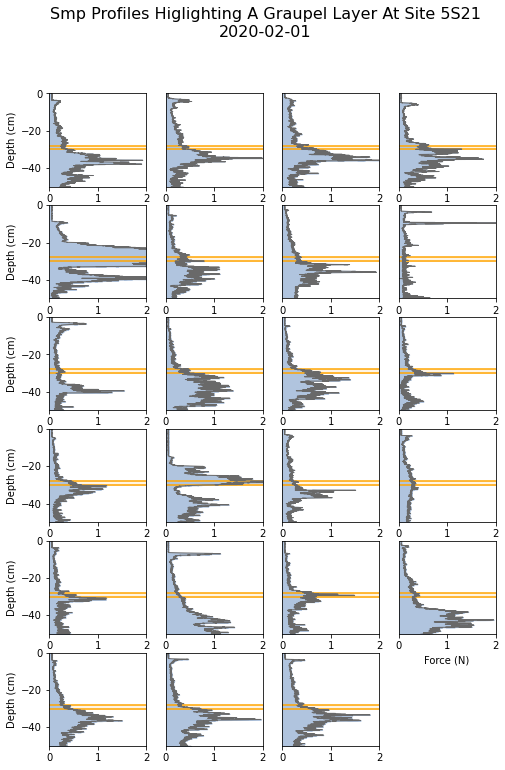

In [8]:
# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df['time'].unique())


# Create a grid of plots thats 4 wide and nrows
xlims = (0,2)
ylims = (-50, 0)

cols = 4
rows = int(np.ceil(len(times) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))


# Loop through all the positions in the plot and plot smp data
for ii in range(rows):
    for jj in range(cols):
        ax = axes[ii][jj]
        
        # Build an index for the times which is 1 x rows*cols
        z = ii * cols + jj
        
        # We may not have an even match between the grid and the times so make sure we don't over index
        if z < len(times):
            
            # Subset all our data to the current time         
            t = times[z]
            ind = df['time'] == t
            data = df.loc[ind].copy()

            # The data returned from the database is not always in order so sort the data according to the depth
            data = data.sort_values(by='depth')

            # All values in the Layer Data are stored as strings, so convert the data to float
            data['value'] = data['value'].astype(float)

            # Highlight the graupel layer boundaries as defined by the layer in hand hardness
            ax.axhline(graupel['depth'], color='orange')
            ax.axhline(graupel['bottom_depth'], color='orange')
            
            ax.fill_between(xlims, graupel['bottom_depth'], graupel['depth'], color='orange', alpha=0.1)

            # Plot the profile vertically with a black border and blue fill
            ax.plot(data['value'], data['depth'], color='dimgrey', linewidth=1)
            ax.fill_betweenx(data['depth'], data['value'], color='lightsteelblue')

            ##### Plot Labeling ######
            
            # Only give the first column a y axis
            if jj != 0:
                ax.yaxis.set_visible(False)
            else:
                ax.set_ylabel('Depth (cm)')
                
            # Only give the bottom row a axis label
            if ii == cols:
                ax.set_xlabel('Force (N)')
           
        # Set our plot limits
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
        
        else:
            # if the index is over the times, then we have no data, turn off the plot
            ax.axis('off')

# Add a title over all the figures
fig.suptitle('SMP Profiles higlighting a graupel layer at Site {}\n{}'.format(site, df['date'].max()).title(), fontsize=16)
plt.show()